## Loading Steinmetz data

In [57]:
%pip install requests --quiet

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns
import pandas as pd
import glob

In [58]:
## Defaults
data_path = './pickled_data/'
plot_path = './plots/'
os.makedirs(data_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)

In [4]:
#@title Data retrieval
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [5]:
#@title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Spike data

In [ ]:
#dataframe with spike info for each session, mouse and trial. Columns signify time bins of 10ms
spike_df = pd.DataFrame() 
#loop through all sessions
for session, data in enumerate(alldat):
    #loop through trial_data from all neurons
    for neuron_num, neuron_data in enumerate(data['spks']):
#         print(neuron_data.shape)
        tmpdf = pd.DataFrame(neuron_data, columns=list(range(neuron_data.shape[1])))
        tmpdf['trial_num'] = tmpdf.index.values
        tmpdf['neuron_num'] = neuron_num 
        tmpdf['neuron_location'] = data['brain_area'][neuron_num]
        tmpdf['session'] = session
        tmpdf['mouse_name'] = data['mouse_name']
        spike_df = pd.concat([spike_df, tmpdf], ignore_index=True)
    if session !=0 and session%10 == 0:
        spike_df.to_pickle(f'{data_path}/mouse_data_{session//10}.pkl')
        spike_df = pd.DataFrame()
    else:
        continue
    
spike_df.to_pickle(f'{data_path}/mouse_data_4.pkl')
spike_df.head()

In [ ]:
spike_df = pd.concat([pd.read_pickle(fname) for fname in glob.glob(f'{data_path}/mouse_data_*')])
spike_df.set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])

In [55]:
spike_df.neuron_location.unique().astype(list)

array(['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG', 'CA1',
       'VISl', 'VISpm', 'POST', 'VISam', 'MG', 'SPF', 'LP', 'MRN', 'NB',
       'LGd', 'TH', 'VPL', 'VISa', 'LSr', 'OLF', 'ORB', 'PL', 'AUD',
       'SSp', 'LD', 'CP', 'EPd', 'PIR', 'ILA', 'TT', 'PO', 'ORBm', 'MB',
       'SCm', 'SCsg', 'POL', 'GPe', 'VISrl', 'MOp', 'LSc', 'PT', 'MD',
       'LH', 'ZI', 'SCs', 'RN', 'MS', 'RSP', 'PAG', 'BLA', 'VPM', 'SSs',
       'RT', 'MEA', 'ACB', 'OT', 'SI', 'SNr', 'APN', 'VAL', 'IC', 'CA2',
       'SCig', 'DP', 'CL', 'EP', 'BMA', 'COA', 'CA'], dtype=object)

In [56]:
(
    spike_df
    .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])
    .groupby(['session', 'mouse_name', 'neuron_location'])
    .mean()
)

,,,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
session,mouse_name,neuron_location,,,,,,,,,,,,,,,,,,,,,
3,Forssmann,VISa,0.013189,0.014031,0.013684,0.013238,0.012990,0.012296,0.013486,0.012841,0.012693,0.012247,...,0.017552,0.017651,0.018196,0.017552,0.017998,0.016312,0.017403,0.018593,0.017899,0.016659
4,Forssmann,VISa,0.007079,0.007954,0.006601,0.005448,0.005567,0.005488,0.006601,0.007158,0.005806,0.006005,...,0.013044,0.013243,0.011930,0.011970,0.012925,0.012845,0.013799,0.012527,0.015072,0.013601
7,Hench,VISa,0.011937,0.010730,0.010222,0.009714,0.009778,0.011873,0.009397,0.010540,0.011937,0.010921,...,0.011365,0.012508,0.014159,0.013905,0.011683,0.011873,0.011619,0.011746,0.012635,0.012063
19,Moniz,VISa,0.020076,0.019367,0.018931,0.020676,0.018058,0.020513,0.018876,0.021113,0.020567,0.022313,...,0.021495,0.022204,0.024768,0.024113,0.021604,0.023350,0.022968,0.023459,0.022477,0.022750
29,Richards,VISa,0.004417,0.006257,0.004785,0.004785,0.004785,0.002944,0.003681,0.003312,0.003312,0.005889,...,0.006257,0.007729,0.010305,0.011410,0.006257,0.009201,0.009201,0.006625,0.007729,0.005153


## Behavioral Data

In [28]:
#data frame for behavioral data for each session mouse and trial
behavior_df = pd.DataFrame()
#loop through all sessions
for session, data in enumerate(alldat):
#     print(session)    
    tmpdf = pd.DataFrame()
    tmpdf['response'] = data['response']
    tmpdf['feedback_type'] = data['feedback_type']
    tmpdf['response_time'] = data['response_time']
    tmpdf['contract_left'] = data['contrast_left']
    tmpdf['contrast_right'] = data['contrast_right']
    tmpdf['go_cue'] = data['gocue']
    tmpdf['trial_num'] = tmpdf.index.values
    tmpdf['session'] = session
    tmpdf['mouse_name'] = data['mouse_name']
    behavior_df = pd.concat([behavior_df, tmpdf], ignore_index=True)

behavior_df.head()

,response,feedback_type,response_time,contract_left,contrast_right,go_cue,trial_num,session,mouse_name
0,1.0,1.0,1.150204,1.0,0.0,1.027216,0,0,Cori
1,-1.0,1.0,1.399503,0.0,0.5,0.874414,1,0,Cori
2,1.0,1.0,0.949291,1.0,0.5,0.825213,2,0,Cori
3,0.0,1.0,2.266802,0.0,0.0,0.761612,3,0,Cori
4,1.0,-1.0,0.816776,0.5,1.0,0.662010,4,0,Cori


In [59]:
behavior_df.set_index(['session', 'mouse_name','trial_num',])

response  feedback_type  response_time  \
session mouse_name trial_num                                           
0       Cori       0               1.0            1.0       1.150204   
                   1              -1.0            1.0       1.399503   
                   2               1.0            1.0       0.949291   
                   3               0.0            1.0       2.266802   
                   4               1.0           -1.0       0.816776   
...                                ...            ...            ...   
38      Theiler    338             0.0           -1.0       2.297503   
                   339            -1.0           -1.0       1.158803   
                   340             0.0           -1.0       2.003709   
                   341             0.0           -1.0       2.076758   
                   342             0.0           -1.0       2.101029   

                              contract_left  contrast_right    go_cue  
session mouse_name trial_num                                           
0       Cori       0                    1.0            0.00  1.027216  
                   1                    0.0            0.50  0.874414  
                   2                    1.0            0.50  0.825213  
                   3                    0.0            0.00  0.761612  
                   4                    0.5            1.00  0.662010  
...                                     ...             ...       ...  
38      Theiler    338                  1.0            0.25  0.794097  
                   339                  1.0            0.25  0.524700  
                   340                  1.0            0.25  0.504257  
                   341                  1.0            0.25  0.574262  
                   342                  1.0            0.25  0.589720  

[10050 rows x 6 columns]

In [60]:
behavior_df.mouse_name.unique() # so cute

array(['Cori', 'Forssmann', 'Hench', 'Lederberg', 'Moniz', 'Muller',
       'Radnitz', 'Richards', 'Tatum', 'Theiler'], dtype=object)

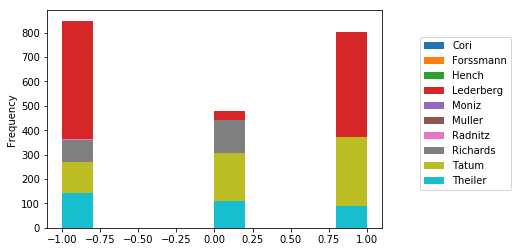

In [70]:
_, ax = plt.subplots()
(
    behavior_df
    .groupby(['mouse_name'])
    .response
    .plot(kind = 'hist', legend=True, stacked=True, ax=ax)
);
ax.legend(bbox_to_anchor=[1.1, 0.9])

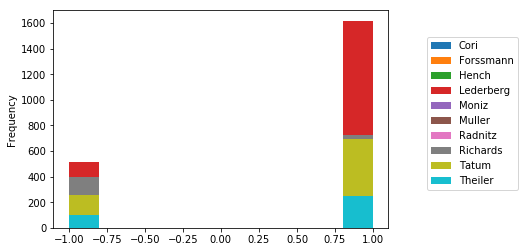

In [72]:
_, ax = plt.subplots()
(
    behavior_df
    .groupby(['mouse_name'])
    .feedback_type
    .plot(kind = 'hist', legend=True, stacked=True, ax=ax)
);
ax.legend(bbox_to_anchor=[1.1, 0.9])

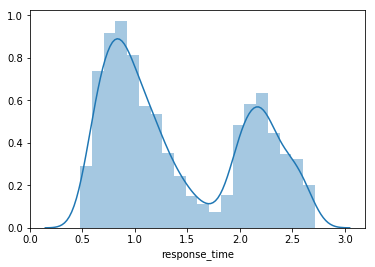

In [73]:
sns.distplot(behavior_df.response_time)